In [1]:
# load libraries
import torch
from robot_env import robot_env
import numpy as np
import pgnn_control as pgnnc
from utils import to_tensors, combine_state, wrap_to_pi, rotate

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# init env
# use the env to get the size of the inputs and outputs
# env = robot_env(show_GUI = False)
env = robot_env(show_GUI = True)
env.reset_terrain()

In [8]:
urdf = 'llllll'
# urdf = 'lnllnl'
# urdf = 'llwwll'
# urdf = 'wnwwnw'
# urdf = 'lwllwl'
# urdf = 'wwwwww'
# urdf = 'wllllw'


iter_num = 1
iter_num = 2
iter_num = 3
# iter_num = 4

folder = 'mbrl_v8_test9/'
folder = 'mbrl_v8_test9NT/'
# folder = 'mbrl_v6_test7/'
# folder = 'mbrl_v4_test20/'
# look for files with this type of name
mpc_save_path = folder+urdf+'_mpc_rollouts_iter' + str(int(iter_num)) + '.ptx'

sampleable_inds= dict()
modules_types = dict()
module_sa_len = dict()
measurement_stds = dict()
attachments = dict()

states_memory = dict()
actions_memory = dict()
torques_memory = dict()
goal_memory = dict()
step_memory = dict()
run_lens = dict()
slew_rate_penalty = dict()



states_memory[urdf] =[]
actions_memory[urdf] =[]
torques_memory[urdf] =[]
goal_memory[urdf] =[]
run_lens[urdf] =[]
step_memory[urdf] = []

# action_list state_list are both lists of divided np
mpc_save_dict = torch.load(mpc_save_path)
states_memory[urdf] += mpc_save_dict['states_memory'] 
actions_memory[urdf] += mpc_save_dict['actions_memory'] 
torques_memory[urdf] += mpc_save_dict['torques_memory'] 
goal_memory[urdf] += mpc_save_dict['goal_memory'] 
step_memory[urdf] += mpc_save_dict['step_memory']
run_lens[urdf] += mpc_save_dict['run_lens'] 

print('loaded ' + mpc_save_path)


slew_rate_penalty[urdf] = mpc_save_dict['slew_rate_penalty']
attachments[urdf] = mpc_save_dict['attachments'] 
modules_types[urdf] = mpc_save_dict['modules_types'] 
module_sa_len[urdf] = mpc_save_dict['module_sa_len'] 

loaded mbrl_v8_test9NT/llllll_mpc_rollouts_iter3.ptx


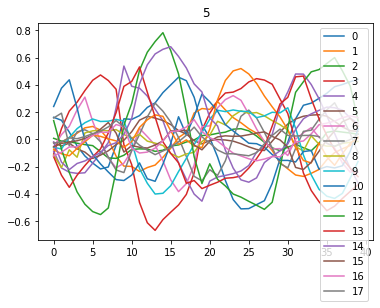

In [9]:
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt

env.reset_robot(urdf_name=urdf, randomize_start=False)
vxy_scale = 1.5
vyaw_scale = 0.5

env.p.resetDebugVisualizerCamera(1.5,0,-25,[0.75,0,0]) 

# # enabling joint torque sensor not needed
# for jind in env.moving_joint_inds:
#     env.p.enableJointForceTorqueSensor(env.robotID,
#             jind,
#             1,
#             physicsClientId=env.physicsClient)
    
# display a trial of the mpc
# for run_choice in range(len(run_lens[urdf])):
# for run_choice in range(6):
env.start_video_log(folder+urdf+'_mpc_rollouts_iter' + str(int(iter_num)) + '.mp4')
for run_choice in [5]:
# for run_choice in range(6):

    tau_list = []
    u_list = []
    run_len = run_lens[urdf][run_choice]

    sampled_state = deepcopy([s[0] for s in states_memory[urdf][run_choice]])
    # need to make a copy  ^ otherwise setting 0 later will mess with the data
    sampled_state[0][0:2] = 0. # set x/y to zero  

    # This shouldnt be necessary but there seems to be some bug where I 
    # need to reset terrain every time, but only in this notebook
#         env.reset_terrain()
    env.reset_robot(urdf_name=urdf, randomize_start=False)
    env.set_state(sampled_state)
#         env.reset_debug_items()

    for i in range(run_len-1): # last action is a NaN

        action = torch.cat([a[i] for a in actions_memory[urdf][run_choice]]).numpy()
        torque = torch.cat([a[i] for a in torques_memory[urdf][run_choice]]).numpy()
        tau_list.append(torque)
        u_list.append(action)

#             index= 3
#             foo = torch.zeros_like(torques_memory[urdf][run_choice][index][i])
#             foo[torques_memory[urdf][run_choice][index][i] == 0] = 1
#             print(torques_memory[urdf][run_choice][index][i] == 0 )
#             print(np.array2string(torque, precision=2))

        env.step(action)
#             print('------')
        joint_states = env.p.getJointStates(env.robotID,
                    env.moving_joint_inds,
                    physicsClientId=env.physicsClient)
#             print([j[3] for j in joint_states])
#             print([j[2] for j in joint_states])
#             print(env.get_ff_torque_approx())
#             print(env.get_ff_torque_approx())


        desired_xyyaw = goal_memory[urdf][run_choice][:,i].numpy()
        chassis_yaw = env.pos_rpy[-1]
        vect1 = np.array([desired_xyyaw[0],
                desired_xyyaw[1],
                0] )
        vect2 = np.array([np.cos(desired_xyyaw[2]+chassis_yaw),
                          np.sin(desired_xyyaw[2]+chassis_yaw), 
                          0])*np.abs(desired_xyyaw[2])
        env.draw_body_arrows([vect1*0.5*vxy_scale, 
                              0.5*vect2*vyaw_scale],
                             [[0,0,0], [0,0,1]])
    
    plt.figure(run_choice)
    u_array = np.stack(u_list)
    all_joint_inds = list(range(env.num_joints))
    jnames = []
    for i in range(len(all_joint_inds)):
        jnames.append(str(i))
        plt.plot(u_array[:,i])
    plt.legend(jnames)
    plt.title(str(run_choice))
env.stop_video_log()

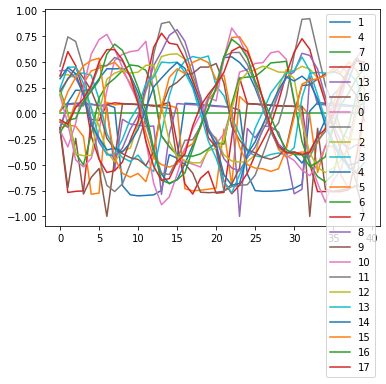

In [4]:
import matplotlib
import matplotlib.pyplot as plt

tau_array = np.stack(tau_list)
all_joint_inds = list(range(env.num_joints))
jnames = []
for i in all_joint_inds[1::3]:
    jnames.append(str(i))
    plt.plot(tau_array[:,i])
plt.legend(jnames)

u_array = np.stack(u_list)

for i in range(len(all_joint_inds)):
    jnames.append(str(i))
    plt.plot(u_array[:,i])
plt.legend(jnames)
